In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Задача:

Будем работать c данными, которые содержат результаты опроса клиентов авиакомпании по поводу их удовлетворённости полётом.

Нашей задачей будет предсказать удовлетворённость пассажиров.

## Знакомство с данными и подготовка

In [302]:
df = pd.read_csv('data/AirPass.csv')
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [303]:
df.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [304]:
df = df.drop('Unnamed: 0', axis=1)

In [305]:
df['Arrival Delay in Minutes'].dtype

dtype('float64')

В датасете 310 пропущенных значений в признаке *Arrival Delay in Minutes*. Так как признак числовой, то заполним пропуски медианным значением.

In [306]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())
df['Arrival Delay in Minutes'].isnull().sum()

0

Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

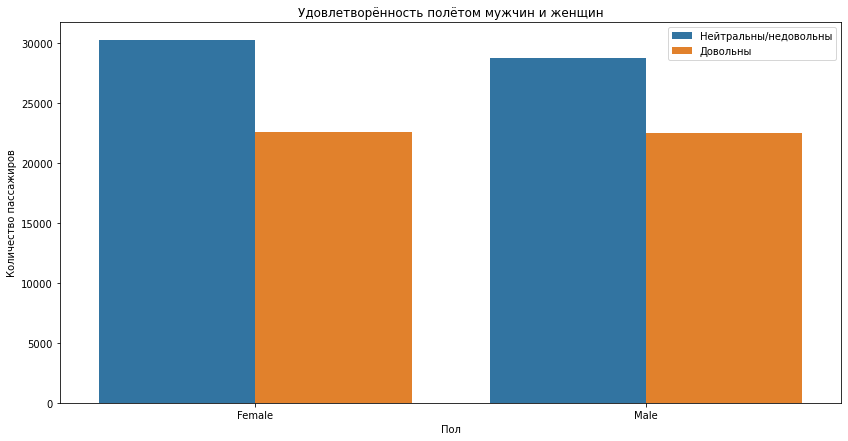

In [307]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(data=df.groupby('Gender', as_index=False)['satisfaction'].value_counts(), x='Gender', y='count', hue='satisfaction', ax=ax)

ax.set_title('Удовлетворённость полётом мужчин и женщин')
ax.set_xlabel('Пол')
ax.set_ylabel('Количество пассажиров')
l = ax.legend()
l.get_texts()[0].set_text('Нейтральны/недовольны')
l.get_texts()[1].set_text('Довольны')

В обеих категориях больше нейтрально настроенных/недовольных.

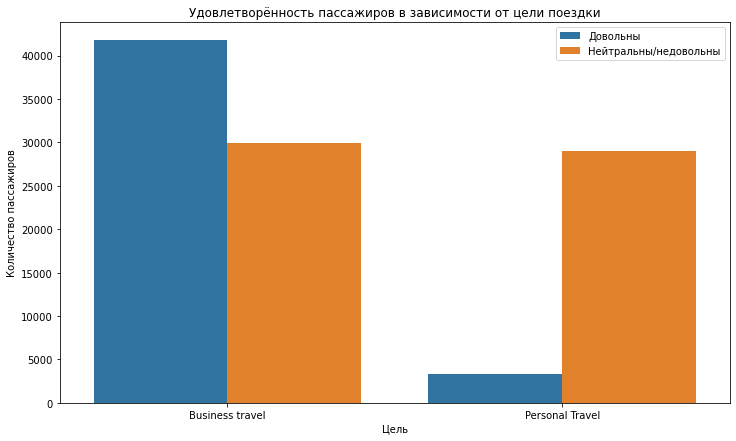

In [308]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data=df.groupby('Type of Travel', as_index=False)['satisfaction'].value_counts(), x='Type of Travel', y='count', hue='satisfaction', ax=ax)

ax.set_title('Удовлетворённость пассажиров в зависимости от цели поездки')
ax.set_xlabel('Цель')
ax.set_ylabel('Количество пассажиров')
l = ax.legend()
l.get_texts()[0].set_text('Довольны')
l.get_texts()[1].set_text('Нейтральны/недовольны')

Среди тех, кто летал в деловую поездку, довольных больше, чем нейтрально настроенных/недовольных.

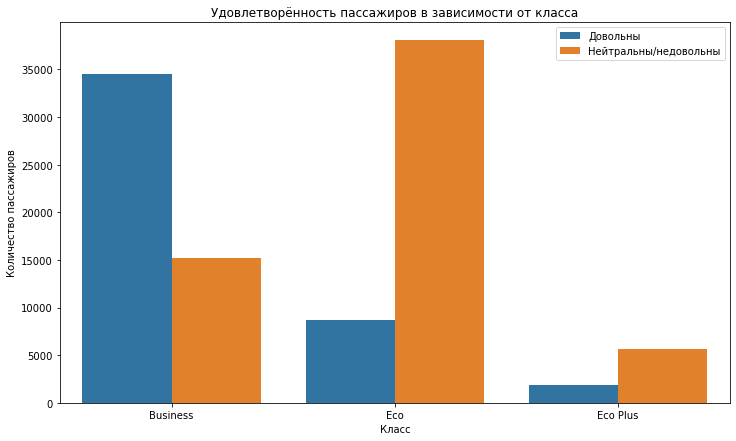

In [309]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data=df.groupby('Class', as_index=False)['satisfaction'].value_counts(), x='Class', y='count', hue='satisfaction', ax=ax)

ax.set_title('Удовлетворённость пассажиров в зависимости от класса')
ax.set_xlabel('Класс')
ax.set_ylabel('Количество пассажиров')
l = ax.legend()
l.get_texts()[0].set_text('Довольны')
l.get_texts()[1].set_text('Нейтральны/недовольны')

Наибольший процент довольных пассажиров в бизнес-классе.

Перекодируем часть бинарных признаков, чтобы использовать их при обучении.

In [310]:
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})

Для остальных категориальных признаков создадим dummy-переменные.

In [311]:
df = pd.get_dummies(df)
df.shape

(103904, 27)

Теперь в датасете 27 признаков, включая целевую переменную.

## Разделение на обучающую и тестовую выборки

In [312]:
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

In [313]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

## Масштабирование данных

Так как данные представлены в разных масштабах и единицах измерения, то их следует отмасштабировать.

In [314]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test);

## Обучение моделей

В качестве первой модели возьмём самую простую — логистическую регрессию, чтобы потом сравнивать с ней полученные результаты.

In [315]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

In [316]:
from sklearn import metrics

print("F1-score on test data is {:.3f}".format(metrics.f1_score(y_test, lr_pred)))

F1-score on test data is 0.855


Теперь перейдём к бустингу. Начнём с обучения первой модели — **AdaBoost**. В качестве базовой модели для неё возьмём решающее дерево.

In [317]:
from sklearn import ensemble
from sklearn import tree

aboost = ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(random_state=26),
                                     learning_rate=0.01,
                                     random_state=26)
aboost.fit(X_train_scaled, y_train)
aboost_pred = aboost.predict(X_test_scaled)

In [318]:
print("F1-score by AdaBoost on test data is {:.3f}".format(metrics.f1_score(y_test, aboost_pred)))

F1-score by AdaBoost on test data is 0.940


Метрика *f1* на тестовом наборе существенно выросла.

Перейдем к следующему алгоритму — **градиентному бустингу**.

Будем настраивать количество деревьев и темп обучения, делая перебор по сетке.

In [321]:
from sklearn.model_selection import GridSearchCV

params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

gsvc = GridSearchCV(estimator=ensemble.GradientBoostingClassifier(),
                    param_grid=params,
                    cv=3,
                    scoring="f1",
                    n_jobs=-1)

gsvc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([1.  , 0.1 , 0.01]),
                         'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128])},
             scoring='f1')

In [322]:
gsvc.best_params_

{'learning_rate': 1.0, 'n_estimators': 128}

In [324]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=128, learning_rate=1, random_state=26)
gbc.fit(X_train_scaled, y_train)
gbc_pred = gbc.predict(X_test_scaled)

In [325]:
print("F1-score by GradientBoostingClassifier on test data is {:.3f}".format(metrics.f1_score(y_test, gbc_pred)))

F1-score by GradientBoostingClassifier on test data is 0.951


Метрика на тестовом наборе подросла.

## XGBoost

In [329]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(random_state=26)
xgbc.fit(X_train_scaled, y_train)
xgbc_pred = xgbc.predict(X_test_scaled)

In [330]:
print("F1-score by XGBClassifier on test data is {:.3f}".format(metrics.f1_score(y_test, xgbc_pred)))

F1-score by XGBClassifier on test data is 0.958


Даже с настройками по умолчанию **XGBClassifier** показывает результат лучше, чем **GradientBoostingClassifier**.

## CatBoost

In [333]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(random_state=26)
cbc.fit(X_train_scaled, y_train)
cbc_pred = cbc.predict(X_test_scaled)

Learning rate set to 0.068023
0:	learn: 0.6008191	total: 35.2ms	remaining: 35.2s
1:	learn: 0.5274362	total: 74.3ms	remaining: 37.1s
2:	learn: 0.4526907	total: 135ms	remaining: 44.8s
3:	learn: 0.4085036	total: 185ms	remaining: 46s
4:	learn: 0.3754344	total: 239ms	remaining: 47.6s
5:	learn: 0.3316901	total: 265ms	remaining: 44s
6:	learn: 0.3110767	total: 281ms	remaining: 39.9s
7:	learn: 0.2929223	total: 301ms	remaining: 37.3s
8:	learn: 0.2731860	total: 317ms	remaining: 34.9s
9:	learn: 0.2584976	total: 339ms	remaining: 33.6s
10:	learn: 0.2433965	total: 359ms	remaining: 32.3s
11:	learn: 0.2327961	total: 374ms	remaining: 30.8s
12:	learn: 0.2245689	total: 385ms	remaining: 29.2s
13:	learn: 0.2158970	total: 398ms	remaining: 28s
14:	learn: 0.2073528	total: 442ms	remaining: 29s
15:	learn: 0.1986441	total: 470ms	remaining: 28.9s
16:	learn: 0.1921238	total: 482ms	remaining: 27.9s
17:	learn: 0.1881224	total: 500ms	remaining: 27.3s
18:	learn: 0.1841778	total: 518ms	remaining: 26.8s
19:	learn: 0.1780

In [334]:
print("F1-score by CatBoostClassifier on test data is {:.3f}".format(metrics.f1_score(y_test, cbc_pred)))

F1-score by CatBoostClassifier on test data is 0.960


Модель **CatBoostClassifier** показада себя чуть лучше, чем  **XGBClassifier**. Это самый высокий результат.

Выведем матрицу ошибок для **CatBoostClassifier**:

In [357]:
from catboost import Pool
from catboost.utils import get_confusion_matrix

cm = get_confusion_matrix(cbc, Pool(X_train_scaled, y_train))
print({'TP': cm[0][0], 'FP': cm[0][1], 'TN': cm[1][0], 'FN':cm[1][1]})

{'TP': 46655.0, 'FP': 551.0, 'TN': 1296.0, 'FN': 34621.0}


Оценим важность признаков для **CatBoostClassifier**.

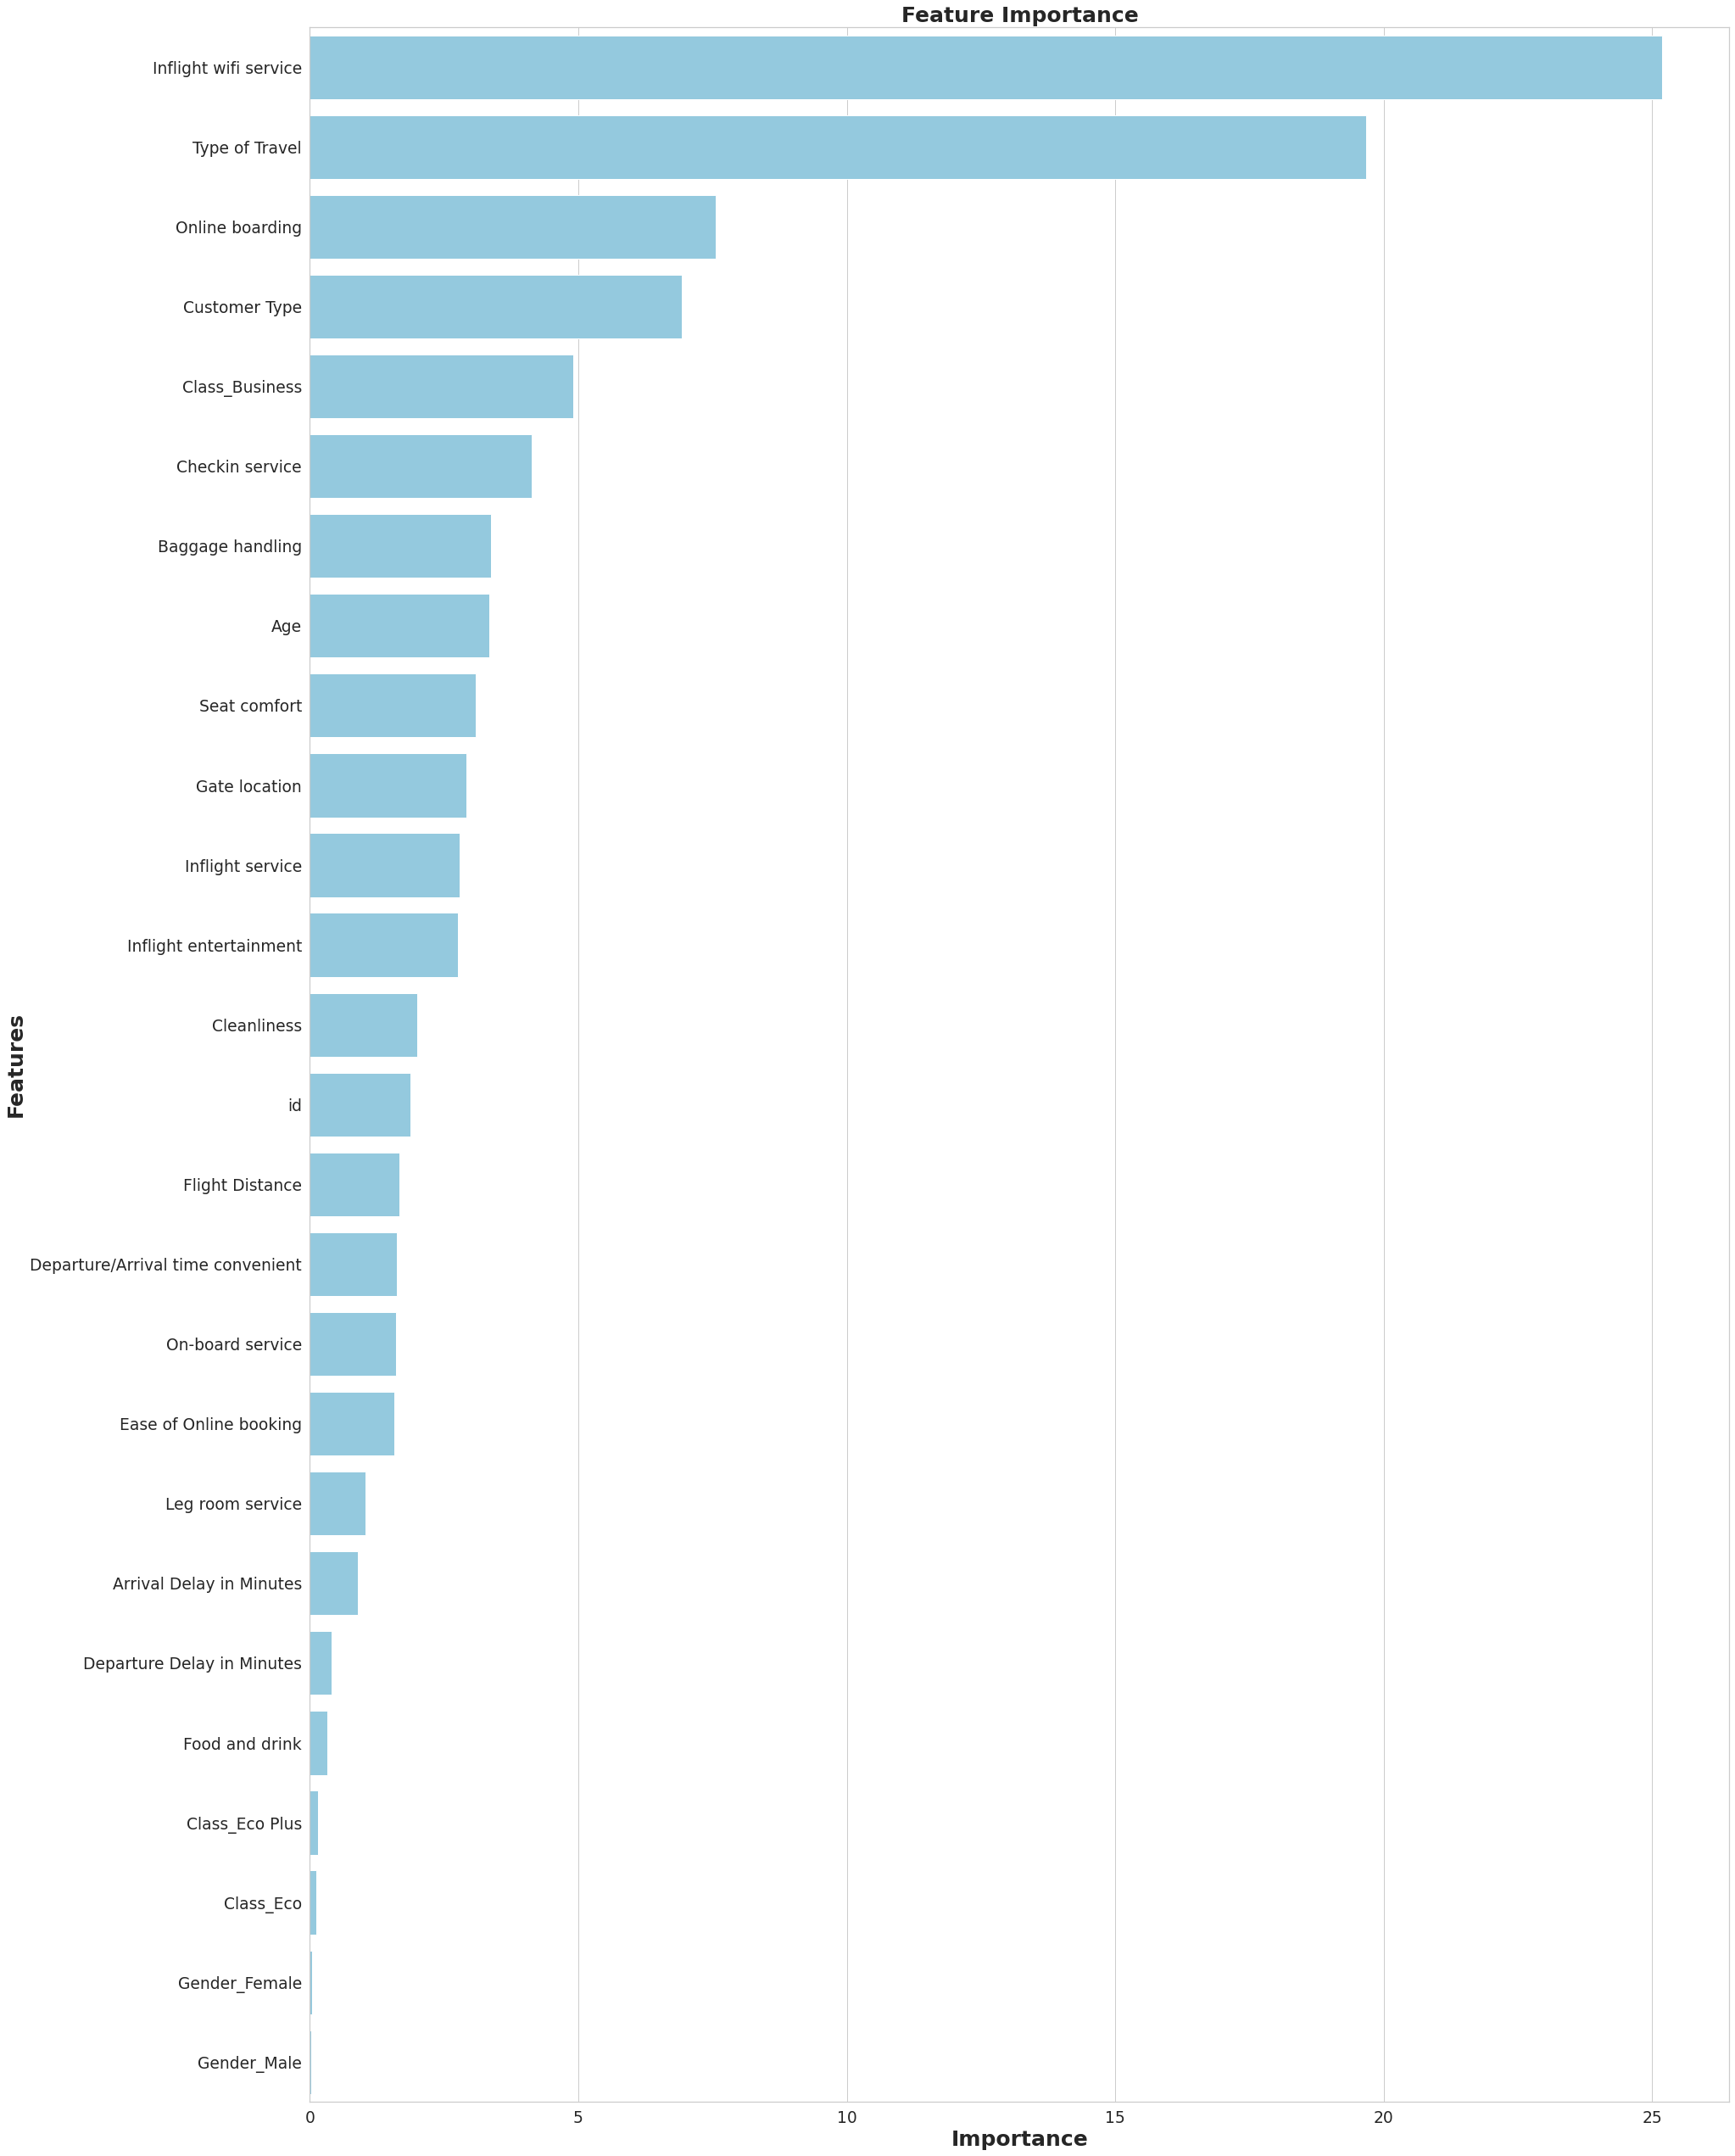

None

,Features,Gini-Importance
0,Inflight wifi service,25.183617
1,Type of Travel,19.680111
2,Online boarding,7.556307
3,Customer Type,6.934594
4,Class_Business,4.903648
5,Checkin service,4.126815
6,Baggage handling,3.380638
7,Age,3.348290
8,Seat comfort,3.094351
9,Gate location,2.914218


In [352]:
feats = {}

for feature, importance in zip(X_train.columns, cbc.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,45)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)